In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

Preparations

In [2]:
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

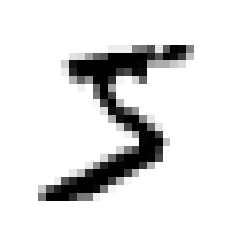

In [7]:
num = X[0]
plt.imshow(num.reshape(28,28), cmap = 'binary')
plt.axis(False)

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8)

In [10]:
def get_distributions(ys):
    unique_elements, counts_elements = np.unique(ys, return_counts=True)
    return pd.Series(counts_elements, index=unique_elements)

In [11]:
#Data is already shuffled
mnist_shuffle = True
if mnist_shuffle:
    X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, shuffle = True, random_state = 42)

In [12]:
get_distributions(y)

0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
dtype: int64

In [13]:
get_distributions(y_train)

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64

Binary Detector 5 Detector

In [14]:
get_distributions(y_test)

0     980
1    1135
2    1032
3    1010
4     982
5     892
6     958
7    1028
8     974
9    1009
dtype: int64

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
y[0]

5

In [18]:
sgd_clf.predict([X[0]])

array([ True])

In [19]:
from sklearn.model_selection import cross_val_score, cross_val_predict
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, n_jobs = -1, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, n_jobs = -1, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

Accuracy is not good when dealing with skewed datasets


In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, n_jobs = -1)


Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

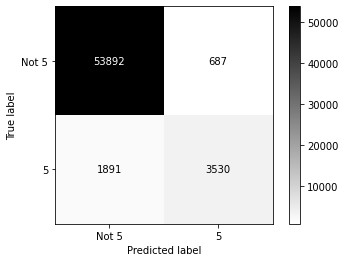

In [24]:
ConfusionMatrixDisplay(cm, display_labels = ['Not 5', "5"]).plot(cmap = 'binary')

Precision, Recall, F1 Scores

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
metrics = {'precision':precision_score, 'recall':recall_score, 'f1':f1_score}
for key in metrics:
    print(f'{key}: {metrics[key](y_train_5, y_train_pred)}')


precision: 0.8370879772350012
recall: 0.6511713705958311
f1: 0.7325171197343846


In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, n_jobs = -1, method = 'decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
def plt_precision_recall_vs_thresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

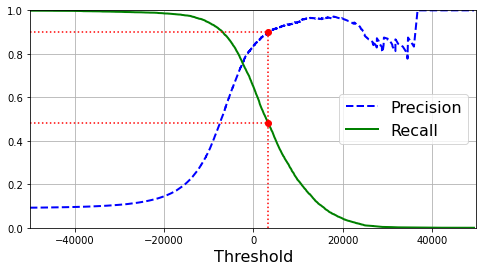

In [29]:
plt.figure(figsize=(8, 4)) 
plt_precision_recall_vs_thresh(precisions, recalls, thresholds)


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro") 

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

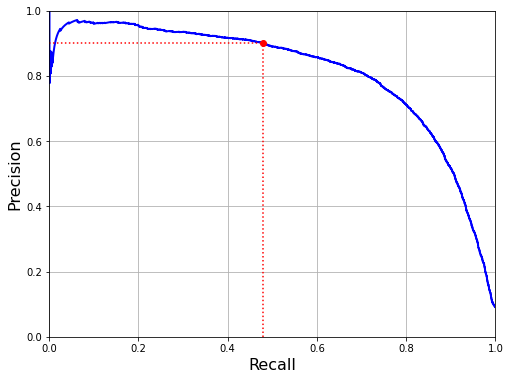

In [31]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

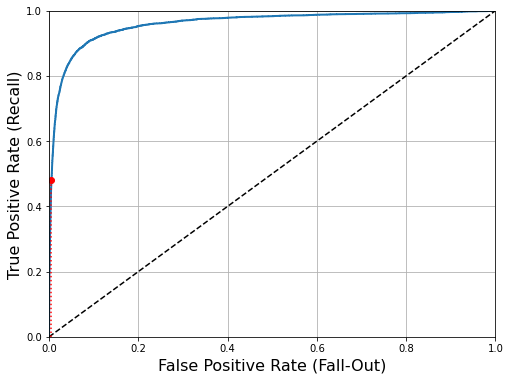

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro") 

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, n_jobs = -1, method = 'predict_proba')
y_probas_forest

array([[0.16, 0.84],
       [0.99, 0.01],
       [0.99, 0.01],
       ...,
       [0.03, 0.97],
       [0.96, 0.04],
       [0.88, 0.12]])

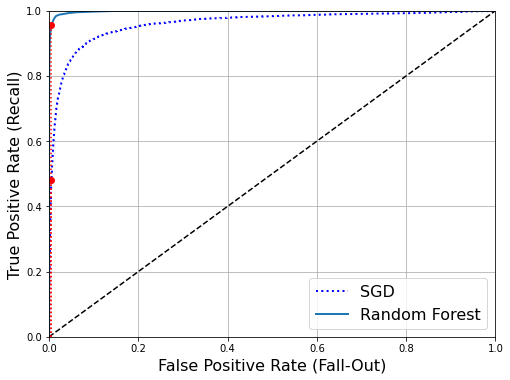

In [36]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984746432840746

In [38]:
y_train_pred_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, n_jobs = -1)

In [39]:
precision_score(y_train_5, y_train_pred_forest)


0.9900969237252423

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8668142409149603

Multiclass Classification

In [41]:
from sklearn.svm import SVC

svm_clf = SVC()

svm_clf.fit(X_train, y_train)
svm_clf.predict([X[0]])


array([5], dtype=uint8)

In [42]:
digit_score = svm_clf.decision_function([X[0]])

In [43]:
svm_clf.classes_[np.argmax(digit_score)]

5

In [44]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([X[0]])
len(ovr_clf.estimators_)

10

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[0]])

array([3], dtype=uint8)

In [46]:
sgd_clf.decision_function([X[0]])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, n_jobs = -1,  scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs = -1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

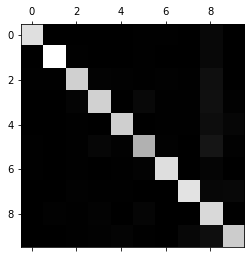

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)